# Timon Spichtinger Machine Learning 2 Modularbeit

In [1]:
from torchvision.datasets import EMNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch
import importlib
from Datensatz import get_emnist_test_train, show_random_samples,create_class_type_map, create_type_labels
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import optuna
from Training import klassifier_training
from Training import train_type_classifier
from Klassifikator import EarlyStopping, ModularClassifier,TypeClassifier, ResNet18, get_objective, train_one_epoch_type, evaluate_model_type, compute_accuracy_type, train_one_epoch_modular, evaluate_model_modular, compute_accuracy_modular
import torch.optim as optim
from Evaluation import evaluate_model

/home/timon/ML2Modularbeit/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.1 Datensatz

Train und Testdaten werden aus Emnist-Datensatz geladen. Falls es zuwenige gibt werden die restlichen Augmentiert

In [2]:
X_train, y_train, X_test, y_test,class_list = get_emnist_test_train()

Ziel-ASCII: [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
Anzahl Zielklassen: 36
⚠️ Klasse B: nur 3878 echte Bilder – augmentiere 2122 zusätzlich.
⚠️ Klasse D: nur 4562 echte Bilder – augmentiere 1438 zusätzlich.
⚠️ Klasse E: nur 4934 echte Bilder – augmentiere 1066 zusätzlich.
⚠️ Klasse G: nur 2517 echte Bilder – augmentiere 3483 zusätzlich.
⚠️ Klasse H: nur 3152 echte Bilder – augmentiere 2848 zusätzlich.
⚠️ Klasse J: nur 3762 echte Bilder – augmentiere 2238 zusätzlich.
⚠️ Klasse K: nur 2468 echte Bilder – augmentiere 3532 zusätzlich.
⚠️ Klasse L: nur 5076 echte Bilder – augmentiere 924 zusätzlich.
⚠️ Klasse b: nur 5159 echte Bilder – augmentiere 841 zusätzlich.
⚠️ Klasse c: nur 2854 echte Bilder – augmentiere 3146 zusätzlich.
⚠️ Klasse f: nur 2561 echte Bilder – augmentiere 3439 zusätzlich.
⚠️ Klasse g: nur 3687 echte Bilder – augmentiere 2313 zusätzlich.
⚠️ Klasse i: nur 272

Stichprobe, ob der Datensatz passt

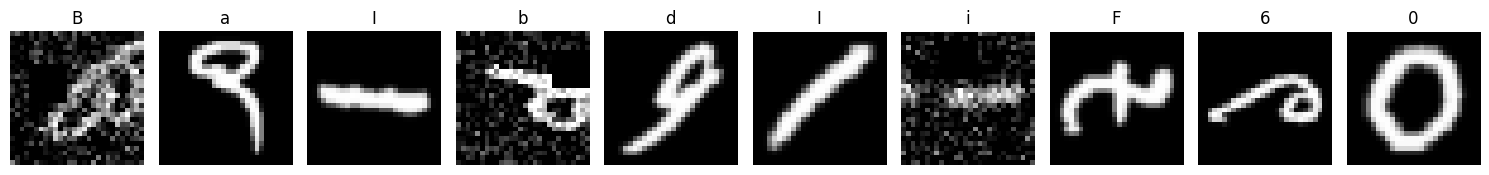

In [12]:

show_random_samples(X_test, y_test, class_list, n=10)

## 1.2 Klassifikator

Im Folgenden soll ein Klassifikator trainiert werden, der die EMNIST-Daten klassifiziert. Ich habe ein Resnet benutzt, da sie keine schwierigkeitem bei höheren Epochen haben

Gerät initialisieren und Tensordatasets erstellen

In [3]:

# Gerät
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)



Die Optina-Studie gibt uns die besten Hyperparameter

In [26]:
# -----------------------------
# Optuna-Studie starten
# -----------------------------
"""

study = optuna.create_study(direction="maximize",
                             storage="sqlite:///optuna_studies.db",
                            study_name="resnet_hyperparam_search4")
study.optimize(get_objective(
          train_dataset=train_dataset,
          test_dataset=test_dataset,
          device=device,
          model=ResNet18(num_classes=len(class_list)).to(device),
          early_stopping=EarlyStopping(),
          train_one_epoch), n_trials=20)

# Beste Parameter anzeigen
print("🎯 Beste Hyperparameter:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

"""
study = optuna.load_study(
    study_name="modular_model_hyperparam_search4",
    storage="sqlite:///optuna_studies.db"
)

In [27]:
# -----------------------------
# Parameter für Finales Training 
# -----------------------------
best_params = study.best_params
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)



model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=best_params["lr"], momentum=best_params["momentum"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=best_params["step_size"], gamma=best_params["gamma"])





Training des Klassifikators

In [ ]:
klassifier_training(train_loader,test_loader,model,device,criterion,optimizer,scheduler,30)


🔁 Epoch 1, Step 200/1407: Batch Loss = 3.0965
🔁 Epoch 1, Step 400/1407: Batch Loss = 2.4888
🔁 Epoch 1, Step 600/1407: Batch Loss = 2.0685
🔁 Epoch 1, Step 800/1407: Batch Loss = 1.5796
🔁 Epoch 1, Step 1000/1407: Batch Loss = 1.2790
🔁 Epoch 1, Step 1200/1407: Batch Loss = 1.1367
🔁 Epoch 1, Step 1400/1407: Batch Loss = 0.8745
📊 Epoch 1: Train Acc = 52.81%, Val Acc = 74.32%, Val Loss = 0.8894, LR = [0.00022409484399187092]
Validation loss decreased (inf --> 0.8894). Saving model state.
🔁 Epoch 2, Step 200/1407: Batch Loss = 0.7995
🔁 Epoch 2, Step 400/1407: Batch Loss = 0.6928
🔁 Epoch 2, Step 600/1407: Batch Loss = 0.6277
🔁 Epoch 2, Step 800/1407: Batch Loss = 0.8181
🔁 Epoch 2, Step 1000/1407: Batch Loss = 0.5904
🔁 Epoch 2, Step 1200/1407: Batch Loss = 0.6634
🔁 Epoch 2, Step 1400/1407: Batch Loss = 0.4059
📊 Epoch 2: Train Acc = 78.72%, Val Acc = 81.52%, Val Loss = 0.5489, LR = [0.00022409484399187092]
Validation loss decreased (0.8894 --> 0.5489). Saving model state.
🔁 Epoch 3, Step 200/140

In [ ]:
# Modell speichern
"""
torch.save(model.state_dict(), './resnet18_best_hyperparams.pth')
print("✅ Modell gespeichert.")
"""

✅ Modell gespeichert.


Evaluierung des Ersten Klassifikators. Es fällt auf das Symbole, die sich ähneln (z.B. 1,I,L), schlechter Vorhergesagt werden können

In [ ]:

evaluate_model(model, test_loader, device, class_list)

Gesamtgenauigkeit des Netzwerks: 87.14 %
Genauigkeit für Klasse 0: 97.10 %
Genauigkeit für Klasse 1: 59.10 %
Genauigkeit für Klasse 2: 96.70 %
Genauigkeit für Klasse 3: 97.60 %
Genauigkeit für Klasse 4: 98.10 %
Genauigkeit für Klasse 5: 98.30 %
Genauigkeit für Klasse 6: 94.60 %
Genauigkeit für Klasse 7: 98.90 %
Genauigkeit für Klasse 8: 96.90 %
Genauigkeit für Klasse 9: 95.40 %
Genauigkeit für Klasse A: 99.10 %
Genauigkeit für Klasse B: 95.50 %
Genauigkeit für Klasse C: 87.80 %
Genauigkeit für Klasse D: 97.40 %
Genauigkeit für Klasse E: 97.00 %
Genauigkeit für Klasse F: 86.80 %
Genauigkeit für Klasse G: 93.90 %
Genauigkeit für Klasse H: 97.70 %
Genauigkeit für Klasse I: 61.40 %
Genauigkeit für Klasse J: 84.20 %
Genauigkeit für Klasse K: 74.60 %
Genauigkeit für Klasse L: 96.00 %
Genauigkeit für Klasse M: 89.10 %
Genauigkeit für Klasse a: 95.20 %
Genauigkeit für Klasse b: 93.50 %
Genauigkeit für Klasse c: 68.50 %
Genauigkeit für Klasse d: 98.80 %
Genauigkeit für Klasse e: 97.80 %
Genauig

87.14444444444445

# 1.3 Modularer Klassifikator

Im folgenden Wird ein Modularer Klassifikator aus unserem

In [4]:
class_type_map = create_class_type_map(class_list)

y_train_type = create_type_labels(y_train, class_list)
y_test_type = create_type_labels(y_test, class_list)

train_dataset = TensorDataset(X_train, y_train, y_train_type)
test_dataset = TensorDataset(X_test, y_test, y_test_type)

In [ ]:

"""
# -----------------------------
# Optuna-Studie starten
# -----------------------------

study = optuna.create_study(direction="maximize",
                             storage="sqlite:///optuna_studies.db",
                            study_name="Type_Classifier_hyperparam_search11")
study.optimize(get_objective(
          train_dataset=train_dataset,
          test_dataset=test_dataset,
          device=device,
          model= TypeClassifier().to(device),
          early_stopping=EarlyStopping(),
          train_fn=train_one_epoch_type,
          eval_fn=evaluate_model_type,
          compute_accuracy_fn=compute_accuracy_type), n_trials=20)

# Beste Parameter anzeigen
print("🎯 Beste Hyperparameter:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")


"""
study = optuna.load_study(
    study_name="Type_Classifier_hyperparam_search11",
    storage="sqlite:///optuna_studies.db"
)

In [12]:
# -----------------------------
# Parameter fü Finales Training 
# -----------------------------
best_params = study.best_params
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)



model =TypeClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=best_params["lr"], momentum=best_params["momentum"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=best_params["step_size"], gamma=best_params["gamma"])


In [14]:
train_type_classifier(train_loader, test_loader, model, device, criterion, optimizer, scheduler, epochs=30)

🔁 Epoch 1, Step 200/2813: Batch Loss = 0.8170
🔁 Epoch 1, Step 400/2813: Batch Loss = 0.7219
🔁 Epoch 1, Step 600/2813: Batch Loss = 0.7777
🔁 Epoch 1, Step 800/2813: Batch Loss = 0.6681
🔁 Epoch 1, Step 1000/2813: Batch Loss = 0.7169
🔁 Epoch 1, Step 1200/2813: Batch Loss = 0.6991
🔁 Epoch 1, Step 1400/2813: Batch Loss = 0.5844
🔁 Epoch 1, Step 1600/2813: Batch Loss = 0.5243
🔁 Epoch 1, Step 1800/2813: Batch Loss = 0.4641
🔁 Epoch 1, Step 2000/2813: Batch Loss = 0.4778
🔁 Epoch 1, Step 2200/2813: Batch Loss = 0.4337
🔁 Epoch 1, Step 2400/2813: Batch Loss = 0.5394
🔁 Epoch 1, Step 2600/2813: Batch Loss = 0.5580
🔁 Epoch 1, Step 2800/2813: Batch Loss = 0.4370
📊 Epoch 1: Train Acc = 71.62%, Val Acc = 78.28%, Val Loss = 0.4942, LR = [0.0003585383114336243]
Validation loss decreased (inf --> 0.4942). Saving model state.
🔁 Epoch 2, Step 200/2813: Batch Loss = 0.5477
🔁 Epoch 2, Step 400/2813: Batch Loss = 0.6006
🔁 Epoch 2, Step 600/2813: Batch Loss = 0.4866
🔁 Epoch 2, Step 800/2813: Batch Loss = 0.3613
🔁

In [ ]:
"""
torch.save(model.state_dict(), './type_classifier_best_hyperparams.pth')
print("✅ Modell gespeichert.")
"""

✅ Modell gespeichert.


In [5]:
# Teilmodelle laden und einfrieren
tm1 = ResNet18(num_classes=36).to(device)
tm1.load_state_dict(torch.load("resnet18_best_hyperparams.pth", map_location=device))
for param in tm1.parameters():
    param.requires_grad = False
for param in tm1.linear.parameters():
    param.requires_grad = True

tm2 = TypeClassifier().to(device)
tm2.load_state_dict(torch.load("type_classifier_best_hyperparams.pth", map_location=device))
for param in tm2.parameters():
    param.requires_grad = False


In [1]:


# -----------------------------
# Optuna-Studie starten
# -----------------------------

study = optuna.create_study(direction="maximize",
                             storage="sqlite:///optuna_studies.db",
                            study_name="Modular_Classifier_hyperparam_search10")
study.optimize(get_objective(
          train_dataset=train_dataset,
          test_dataset=test_dataset,
          device=device,
          model= ModularClassifier(tm1,tm2,class_type_map).to(device),
          early_stopping=EarlyStopping(),
          train_fn=train_one_epoch_modular,
          eval_fn=evaluate_model_modular,
          compute_accuracy_fn=compute_accuracy_modular), n_trials=20)

# Beste Parameter anzeigen
print("🎯 Beste Hyperparameter:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")


tudy = optuna.load_study(
    study_name="Modular_Classifier_hyperparam_search10",
       storage="sqlite:///optuna_studies.db"
)


NameError: name 'optuna' is not defined

In [6]:
# -----------------------------
# Parameter für Finales Training 
# -----------------------------


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)



model =ModularClassifier(tm1,tm2,class_type_map).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0018460023232891255, momentum=0.6076939425444646)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma= 0.7858173311049056)

In [7]:
def train_modular_classifier(model, train_loader, test_loader, device, optimizer, scheduler=None, epochs=50):
    early_stopping = EarlyStopping(patience=5, delta=0.001, verbose=True)
    best_accuracy = 0.0
    criterion = nn.CrossEntropyLoss()

    def evaluate(model, loader):
        model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels_cls, labels_type in loader:
                images = images.to(device)
                labels_cls = labels_cls.to(device)
                labels_type = labels_type.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels_cls)

                total_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels_cls).sum().item()
                total += labels_cls.size(0)

        avg_loss = total_loss / total
        accuracy = 100.0 * correct / total
        return avg_loss, accuracy

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels_cls, labels_type in train_loader:
            images = images.to(device)
            labels_cls = labels_cls.to(device)
            labels_type = labels_type.to(device)

            optimizer.zero_grad()

            # Vorhersagen getrennt berechnen
            out_cls = model.tm1(images)
            out_type = model.tm2(images)
            combined_output = model(images)

            # Verluste berechnen
            loss_cls = criterion(combined_output, labels_cls)
            loss_type = criterion(out_type, labels_type)

            # Kombinierter Verlust
            loss = loss_cls + 0.5 * loss_type  # Gewichtung optional anpassbar

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(combined_output, 1)
            correct_train += (predicted == labels_cls).sum().item()
            total_train += labels_cls.size(0)

        if scheduler:
            scheduler.step()

        avg_train_loss = running_loss / total_train
        train_acc = 100.0 * correct_train / total_train
        val_loss, val_acc = evaluate(model, test_loader)

        print(f"📊 Epoche {epoch+1}/{epochs}: "
              f"Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.2f}%, "
              f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%, "
              f"LR = {scheduler.get_last_lr()[0] if scheduler else 'N/A'}")

        if val_acc > best_accuracy:
            best_accuracy = val_acc

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"🛑 Early Stopping bei Epoche {epoch+1} (Beste Val Acc: {best_accuracy:.2f}%)")
            break

    if early_stopping.best_model_state is not None:
        model.load_state_dict(early_stopping.best_model_state)
        print("✅ Bestes Modell wiederhergestellt.")
    else:
        print("⚠️ Kein besseres Modell als Initialzustand gefunden.")

    return model






In [8]:
model =ModularClassifier(tm1,tm2,class_type_map).to(device)
train_modular_classifier(model, train_loader, test_loader, device, optimizer, scheduler, epochs=50)

📊 Epoche 1/50: Train Loss = 3.7637, Train Acc = 2.69%, Val Loss = 3.5882, Val Acc = 2.42%, LR = 0.0018460023232891255
Validation loss decreased (inf --> 3.5882). Saving model state.
📊 Epoche 2/50: Train Loss = 3.7630, Train Acc = 2.74%, Val Loss = 3.5879, Val Acc = 2.34%, LR = 0.0018460023232891255
EarlyStopping counter: 1/5
📊 Epoche 3/50: Train Loss = 3.7630, Train Acc = 2.67%, Val Loss = 3.5876, Val Acc = 2.26%, LR = 0.0018460023232891255
EarlyStopping counter: 2/5
📊 Epoche 4/50: Train Loss = 3.7624, Train Acc = 2.66%, Val Loss = 3.5874, Val Acc = 2.33%, LR = 0.0014506206189005158
EarlyStopping counter: 3/5
📊 Epoche 5/50: Train Loss = 3.7628, Train Acc = 2.66%, Val Loss = 3.5872, Val Acc = 2.27%, LR = 0.0014506206189005158
EarlyStopping counter: 4/5


KeyboardInterrupt: 

{'batch_size': 64,
 'lr': 0.0012540729304007245,
 'momentum': 0.6645569703384998,
 'step_size': 3,
 'gamma': 0.8046924609772251}